## Part 1

In [1]:
import numpy as np
from statsmodels.sandbox.regression.gmm import GMM

In [2]:
import pandas as pd
import statsmodels.api as sm

In [3]:
# Load the dataset to inspect its structure and understand the variables involved
file_path = '/Users/divvuuuuuu/Desktop/MBAN- Schulich/term 2/predictive modelling/mid term/midterm_partone.csv'
data = pd.read_csv(file_path)


In [4]:
data.head()

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446


In [5]:
# Stage 1: Predict Inventory Turnover using instrumental variables
X_iv = data[["Constant", "Current Ratio", "Quick Ratio", "Debt Asset Ratio"]]
y_iv = data["Inventory Turnover"]
model_iv = sm.OLS(y_iv, X_iv).fit()
data["Endogenous Param"] = model_iv.predict(X_iv)


In [6]:
# Stage 2: Use the predicted values as an exogenous regressor in the main model
X_2sls = data[["Constant", "Endogenous Param", "Operating Profit", "Interaction Effect"]]
y_2sls = data["Stock Change"]
model_2sls = sm.OLS(y_2sls, X_2sls).fit()
print(model_2sls.summary())


                            OLS Regression Results                            
Dep. Variable:           Stock Change   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     8.530
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           1.27e-05
Time:                        14:15:26   Log-Likelihood:                -1186.5
No. Observations:                1696   AIC:                             2381.
Df Residuals:                    1692   BIC:                             2403.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Constant              -0.0176      0

In [7]:
# Define the variables for the GMM model
y = data["Stock Change"].values
X = data[["Inventory Turnover", "Operating Profit", "Interaction Effect"]].values
X = np.column_stack((np.ones(len(X)), X))  # Add a column of ones for the intercept
Z = data[["Current Ratio", "Quick Ratio", "Debt Asset Ratio"]].values

In [8]:
# Define a custom GMM class with the moment conditions
class SimpleGMM(GMM):
    def momcond(self, params):
        # Calculate residuals
        residuals = y - np.dot(X, params)
        
        # Moment conditions: Z' * residuals = 0
        moment_conditions = (Z * residuals[:, None])
        
        return moment_conditions



In [9]:
# Initial parameter estimates based on OLS results
initial_params = np.array([-0.0176, 0.0011, -0.1201, 0.0014])



In [11]:
# Create an identity matrix for weights with the same number of moment conditions
initial_weights = np.eye(Z.shape[1])

# Fit the model with the identity weights
model = SimpleGMM(y, X, Z)
result = model.fit(start_params=initial_params, maxiter=1000, inv_weights=initial_weights, optim_method='bfgs')


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


In [12]:
# Output the GMM results
print(result.summary())

                              SimpleGMM Results                               
Dep. Variable:                      y   Hansen J:                    2.384e-18
Model:                      SimpleGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Sun, 10 Nov 2024                                         
Time:                        14:18:50                                         
No. Observations:                1696                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0175   1.03e+06   -1.7e-08      1.000   -2.03e+06    2.03e+06
x1            -0.0023    2.8e+04  -8.03e-08      1.000   -5.49e+04    5.49e+04
x2            -0.1198   4.04e+06  -2.96e-08      1.000   -7.93e+06    7.93e+06
x3             0.0132   9.38e+04   1.41e-07      1.0

In [13]:
# Calculate correlations between each instrument and Inventory Turnover

correlations = data[["Current Ratio", "Quick Ratio", "Debt Asset Ratio", "Inventory Turnover"]].corr()
correlations_with_turnover = correlations["Inventory Turnover"].drop("Inventory Turnover")
print("Correlations with Inventory Turnover:\n", correlations_with_turnover)


Correlations with Inventory Turnover:
 Current Ratio      -0.318751
Quick Ratio        -0.058093
Debt Asset Ratio    0.176419
Name: Inventory Turnover, dtype: float64


In [14]:
import statsmodels.api as sm

# Define the endogenous variable (Inventory Turnover) and instruments
y_iv = data["Inventory Turnover"]
X_iv = data[["Current Ratio", "Quick Ratio", "Debt Asset Ratio"]]
X_iv = sm.add_constant(X_iv)  # Add constant term

# Perform the first-stage regression
first_stage_model = sm.OLS(y_iv, X_iv).fit()
print(first_stage_model.summary())


                            OLS Regression Results                            
Dep. Variable:     Inventory Turnover   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     258.4
Date:                Sun, 10 Nov 2024   Prob (F-statistic):          5.04e-138
Time:                        14:19:06   Log-Likelihood:                -8212.4
No. Observations:                1696   AIC:                         1.643e+04
Df Residuals:                    1692   BIC:                         1.645e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               46.4258      1.434  

In [15]:
#2SLS Model

from statsmodels.sandbox.regression.gmm import IV2SLS

In [16]:
#defining variables

y = data["Stock Change"]  # Dependent variable
X_endog = data["Inventory Turnover"]  # Endogenous variable
X_exog = data[["Operating Profit", "Interaction Effect"]]  # Exogenous variables

In [17]:
# Define the instruments
Z = data[["Current Ratio", "Quick Ratio", "Debt Asset Ratio"]]  # Instruments

In [18]:
# Add a constant to both exogenous and instruments
X_exog = sm.add_constant(X_exog)
Z = sm.add_constant(Z)

In [19]:
# Combine exogenous and endogenous variables for 2SLS
X_full = sm.add_constant(pd.concat([X_endog, X_exog], axis=1))

In [20]:
# Run the 2SLS model
model_2sls = IV2SLS(y, X_full, instrument=Z).fit()

# Output the 2SLS results
print(model_2sls.summary())

                          IV2SLS Regression Results                           
Dep. Variable:           Stock Change   R-squared:                      -0.615
Model:                         IV2SLS   Adj. R-squared:                 -0.618
Method:                     Two Stage   F-statistic:                     1.321
                        Least Squares   Prob (F-statistic):              0.266
Date:                Sun, 10 Nov 2024                                         
Time:                        14:27:46                                         
No. Observations:                1696                                         
Df Residuals:                    1692                                         
Df Model:                           3                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Inventory Turnover    -0.0009      0

## Part 2

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import numpy as np

In [3]:
# Load the dataset
file_path = '/Users/divvuuuuuu/Desktop/MBAN- Schulich/term 2/predictive modelling/mid term/midterm_parttwo.csv'
data = pd.read_csv(file_path)

In [4]:
# Encode the target variable (Credit Rating)
data['Credit Rating'] = data['Credit Rating'].apply(lambda x: 1 if x == 'Positive' else 0)

In [5]:
# Encode categorical features using LabelEncoder
label_encoders = {}
for col in ['Requested Credit Amount', 'Number of Dependents', 'Monthly Income', 'Monthly Expense', 'Marital Status']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


In [6]:
# Define feature and target variables
X = data.drop(columns=['Credit Rating'])
y = data['Credit Rating']

In [7]:
# Split the dataset equally into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [8]:
# Initialize and fit the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [9]:
# Predict on the test set
y_pred = log_reg.predict(X_test)

In [10]:
# Calculate initial evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


In [11]:
# Display initial results
print("Initial Confusion Matrix:\n", conf_matrix)
print("Initial Recall:", recall)
print("Initial Precision:", precision)
print("Initial F1 Score:", f1)

Initial Confusion Matrix:
 [[   0  577]
 [   0 3464]]
Initial Recall: 1.0
Initial Precision: 0.8572135609997525
Initial F1 Score: 0.9231179213857429


### Credit Approval Process became stricter

In [12]:
# Get the prediction probabilities for the test set (Probabilities for the positive class)
y_proba = log_reg.predict_proba(X_test)[:, 1]  


In [13]:
# Calculate the threshold for the top 15% applications
threshold = np.percentile(y_proba, 85)

In [14]:
# Apply the threshold to get new predictions
y_pred_adjusted = (y_proba >= threshold).astype(int)

In [15]:
# Calculate adjusted metrics
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
recall_adjusted = recall_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)
f1_adjusted = f1_score(y_test, y_pred_adjusted)


In [16]:
# Display adjusted results
print("\nAdjusted Threshold:", threshold)
print("Adjusted Confusion Matrix:\n", conf_matrix_adjusted)
print("Adjusted Recall:", recall_adjusted)
print("Adjusted Precision:", precision_adjusted)
print("Adjusted F1 Score:", f1_adjusted)



Adjusted Threshold: 0.8785917263593007
Adjusted Confusion Matrix:
 [[ 506   71]
 [2928  536]]
Adjusted Recall: 0.15473441108545036
Adjusted Precision: 0.8830313014827018
Adjusted F1 Score: 0.2633259641365758


In [17]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


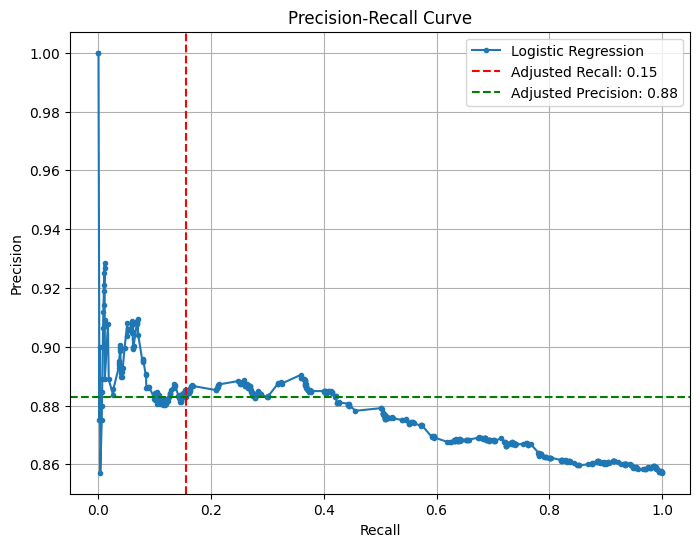

In [18]:
# Generate precision-recall values across thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.', label='Logistic Regression')
plt.axvline(x=recall_adjusted, color='r', linestyle='--', label=f'Adjusted Recall: {recall_adjusted:.2f}')
plt.axhline(y=precision_adjusted, color='g', linestyle='--', label=f'Adjusted Precision: {precision_adjusted:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()